Task 1

The dataset encompasses 21 columns and 9994 rows of customer and order information. There are four key numeric columns Sales, Profit, Quantity and discount that provide insights around financial performance of the business and are candidates for feature engineering.

The remaining columns are categorical by nature and fall into two groups which are products with product_id, categories, sub-categories with some logistical information. The final set of categoricals covers customer address information. Unfortunately, the dataset has 59 missing values, NaNs in numerical fields and numeric columns classified as objects, not float64 as expected. This will present a challenge when deriving insights.

In [117]:
import pandas as pd
import numpy as np
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats




file_path = "/Users/godfreykrutzsch/Desktop/MSc/Assignment/samplesuperstore2023T3.csv"
df_customer_order_info = pd.read_csv(file_path)

print(df_customer_order_info.head(10))

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0    7773  CA-2016-108196  25/11/2016  12/02/2016  Standard Class    CS-12505   
1     684  US-2017-168116  11/04/2017  11/04/2017        Same Day    GT-14635   
2    9775  CA-2014-169019  26/07/2014  30/07/2014  Standard Class    LF-17185   
3    3012  CA-2017-134845  17/04/2017  24/04/2017  Standard Class    SR-20425   
4    4992  US-2017-122714  12/07/2017  13/12/2017  Standard Class    HG-14965   
5    3152  CA-2015-147830  15/12/2015  18/12/2015     First Class    NF-18385   
6    5311  CA-2017-131254  19/11/2017  21/11/2017     First Class    NC-18415   
7    9640  CA-2015-116638  28/01/2015         NaN    Second Class    JH-15985   
8    1200  CA-2016-130946  04/08/2016  04/12/2016  Standard Class    ZC-21910   
9    2698  CA-2014-145317  18/03/2014  23/03/2014  Standard Class    SM-20320   

      Customer Name      Segment        Country          City  ...  \
0     Cindy Stewart     Consumer  Unit

Task 2

1.0 Exploratory Data Analysis

Key observation: The dtype for profit and quantity are objects not Float 64 like discount and sales. This will limit our ability to undertake covariance and coeffcient analysis unless resolved.

In [86]:
print(df_customer_order_info.shape)
print("verify features", df_customer_order_info.columns)

(9994, 21)
verify features Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


In [87]:
print(df_customer_order_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9993 non-null   object 
 2   Order Date     9992 non-null   object 
 3   Ship Date      9991 non-null   object 
 4   Ship Mode      9990 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9991 non-null   object 
 7   Segment        9991 non-null   object 
 8   Country        9990 non-null   object 
 9   City           9992 non-null   object 
 10  State          9990 non-null   object 
 11  Postal Code    9991 non-null   object 
 12  Region         9991 non-null   object 
 13  Product ID     9992 non-null   object 
 14  Category       9992 non-null   object 
 15  Sub-Category   9990 non-null   object 
 16  Product Name   9991 non-null   object 
 17  Sales          9993 non-null   float64
 18  Quantity

A requirement of descriptive analysis and feature engineering is good numeric data devoid of NaNs and missing values. This “so called” preprocessing must be undertaken first as the alternative is that we cannot perform median, skew, kurtosis, coefficient of sales, profits, quantity and discounting, nor can we look at linear relationships between key numeric sales and say profits. Therefore for effectiveness of descriptive analysis data-cleaning is a requirement.

In [88]:
print(df_customer_order_info.isnull().sum())

missing values and pesky nans:
Row ID            0
Order ID          1
Order Date        2
Ship Date         3
Ship Mode         4
Customer ID       0
Customer Name     3
Segment           3
Country           4
City              2
State             4
Postal Code       3
Region            3
Product ID        2
Category          2
Sub-Category      4
Product Name      3
Sales             1
Quantity          5
Discount          3
Profit           11
dtype: int64


For the next steps i will remove NaNs and missing values from the entire dataset. To maintain the integrity of the underlying data i will use the Ramdom Forrest regressor with the iterative impute. These techniques go beyond just using the mean to plug missing values.

1.1 Data preprocessing

First we put all numeric features in a dataframe.

In [89]:
df_numeric_cust_features = pd.DataFrame()
df_numeric_cust_features['Sales'] = df_customer_order_info['Sales']
df_numeric_cust_features['Quantity'] = df_customer_order_info['Quantity']
df_numeric_cust_features['Discount'] = df_customer_order_info['Discount']
df_numeric_cust_features['Profit'] = df_customer_order_info['Profit']

print("numeric features", df_numeric_cust_features)
print("numeric feature shape", df_numeric_cust_features.shape)

numeric features           Sales Quantity  Discount      Profit
0      4499.985        5       0.7   -6599.978
1      7999.980        4       0.5  -3839.9904
2      2177.584        8       0.8  -3701.8928
3      2549.985        5       0.7    -3399.98
4      1889.990        5       0.8  -2929.4845
...         ...      ...       ...         ...
9989   9449.950        5       0.0   4630.4755
9990   9892.740       13       0.0     4946.37
9991  10499.970        3       0.0   5039.9856
9992  13999.960        4       0.0   6719.9808
9993  17499.950        5       0.0    8399.976

[9994 rows x 4 columns]
numeric feature shape (9994, 4)


1.2 Data processing

Group categorical set into single datafram.

In [90]:

df_categorical_cust_info = df_customer_order_info
df_categorical_cust_info.drop('Sales', axis=1, inplace=True)
df_categorical_cust_info.drop('Quantity', axis=1, inplace=True)
df_categorical_cust_info.drop('Discount', axis=1, inplace=True)
df_categorical_cust_info.drop('Profit', axis=1, inplace=True)

print("categorical features", df_categorical_cust_info)
print("categorical feature shape", df_categorical_cust_info.shape)

categorical features       Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
0       7773  CA-2016-108196  25/11/2016  12/02/2016  Standard Class   
1        684  US-2017-168116  11/04/2017  11/04/2017        Same Day   
2       9775  CA-2014-169019  26/07/2014  30/07/2014  Standard Class   
3       3012  CA-2017-134845  17/04/2017  24/04/2017  Standard Class   
4       4992  US-2017-122714  12/07/2017  13/12/2017  Standard Class   
...      ...             ...         ...         ...             ...   
9989    4099  CA-2014-116904  23/09/2014  28/09/2014  Standard Class   
9990    9040  CA-2016-117121  17/12/2016  21/12/2016  Standard Class   
9991    4191  CA-2017-166709  17/11/2017  22/11/2017  Standard Class   
9992    8154  CA-2017-140151  23/03/2017  25/03/2017     First Class   
9993    6827  CA-2016-118689  10/02/2016  10/09/2016  Standard Class   

     Customer ID   Customer Name      Segment        Country         City  \
0       CS-12505   Cindy Stewart     

1.3 Data preprocessing

Eliminate bad data in Quantity field for downstream descriptive analysis.


In [91]:
for column in df_numeric_cust_features.columns:
    unique_values = df_numeric_cust_features[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in Sales: [ 4499.985  7999.98   2177.584 ... 10499.97  13999.96  17499.95 ]
Unique values in Quantity: ['5' '4' '8' 'Two' '6' 'Thirteen' '7' '3' 'Seven' '9' nan '12' '2' 'ten'
 '10' '7?' '1' '14' '13' '11']
Unique values in Discount: [0.7  0.5  0.8  0.4  0.2  0.3  0.45 0.32 0.6   nan 0.15 0.1  0.  ]
Unique values in Profit: ['-6599.978' '-3839.9904' '-3701.8928' ... '5039.9856' '6719.9808'
 '8399.976']


This highlighted the problem in Quantity which i resolved using the simple replace method to ensure all values in this column are float64.

In [206]:

df_numeric_cust_features['Quantity'] = df_numeric_cust_features['Quantity'].replace("Two", 2)
df_numeric_cust_features['Quantity'] = df_numeric_cust_features['Quantity'].replace("Thirteen", 13)
df_numeric_cust_features['Quantity'] = df_numeric_cust_features['Quantity'].replace("Seven", 7)
df_numeric_cust_features['Quantity'] = df_numeric_cust_features['Quantity'].replace("7?", 7)
df_numeric_cust_features['Quantity'] = df_numeric_cust_features['Quantity'].replace("ten", 7)
df_numeric_cust_features['Quantity'] = df_numeric_cust_features['Quantity'].replace("Seven", 7)

# like with like for all numerics
df_numeric_cust_features['Quantity'].astype(float)

0        5.0
1        4.0
2        8.0
3        5.0
4        5.0
        ... 
9989     5.0
9990    13.0
9991     3.0
9992     4.0
9993     5.0
Name: Quantity, Length: 9994, dtype: float64

In [211]:
df_numeric_cust_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     9994 non-null   float64
 1   Quantity  9994 non-null   float64
 2   Discount  9994 non-null   float64
 3   Profit    9994 non-null   float64
dtypes: float64(4)
memory usage: 312.4 KB


1.4 data preprocessing: impute

Plug missing values and NaNs in numeric dataset 

In [208]:
imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=0), max_iter=10, random_state=0)

# df_numeric_cust_features['Quantity'] = pd.DataFrame(df_numeric_cust_features['Quantity'])
df_numeric_cust_features['Quantity'] = imputer.fit_transform(df_numeric_cust_features[['Quantity']])


#df_numeric_cust_features['Sales'] = pd.DataFrame(df_numeric_cust_features['Sales'])
df_numeric_cust_features['Sales'] = imputer.fit_transform(df_numeric_cust_features[['Sales']])


#df_numeric_cust_features['Discount'] = pd.DataFrame(df_numeric_cust_features['Discount'])
df_numeric_cust_features['Discount'] = imputer.fit_transform(df_numeric_cust_features[['Discount']])


df_numeric_cust_features.info()
print(df_numeric_cust_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     9994 non-null   float64
 1   Quantity  9994 non-null   float64
 2   Discount  9994 non-null   float64
 3   Profit    9994 non-null   float64
dtypes: float64(4)
memory usage: 312.4 KB
         Sales  Quantity  Discount     Profit
0     0.777575       5.0       0.7 -6599.9780
1     0.785873       4.0       0.5 -3839.9904
2     0.765993       8.0       0.8 -3701.8928
3     0.768629       5.0       0.7 -3399.9800
4     0.763568       5.0       0.8 -2929.4845
...        ...       ...       ...        ...
9989  0.788148       5.0       0.0  4630.4755
9990  0.788764      13.0       0.0  4946.3700
9991  0.789559       3.0       0.0  5039.9856
9992  0.793309       4.0       0.0  6719.9808
9993  0.796118       5.0       0.0  8399.9760

[9994 rows x 4 columns]


1.5 Data processing

Confirm all bad data is eliminated 



In [16]:
df_numeric_cust_features.isnull().sum()

Sales        0
Quantity     0
Discount     0
Profit      11
dtype: int64

1.6 Data processioning: Profit bad data

Use Random to predict values for missing values and fix bad data.


In [213]:
df_numeric_cust_features['Profit'] = df_numeric_cust_features['Profit'].apply(lambda x: str(x).replace('"', '').strip())


df_numeric_cust_features['Profit'].astype(float)
# df_numeric_cust_features['Profit'] = pd.DataFrame(df_numeric_cust_features['Profit'])
df_numeric_cust_features['Profit'] = imputer.fit_transform(df_numeric_cust_features[['Profit']])


Check to ensure there are no blanks or NaNs left in Profit and that it is clean.

In [214]:
profit_nan =df_numeric_cust_features['Profit'].isna().sum()
print(profit_nan)

0


1.6.1 A quick sense check and review of numeric data to confirm it is now super clean.

In [215]:
numeric_file_path = "/Users/godfreykrutzsch/Desktop/MSc/Assignment/SenseCheck.csv"
df_numeric_cust_features.to_csv(numeric_file_path, index=True)

Task 2

2.1 Descriptive statistics analysis.

* There is a material difference between the mean 229 and the median 54 in sales.
* This indicates there are substantial outliers in the sales numbers.
* These outliers influence the mean and make it less representative.
* The mean (229) is significantly greater than the median (54) which means it is positively skewed (right skewed) and the median represents the sales data better for decision making


In [37]:
df_numeric_cust_features['Sales'].mean()

229.8637796757731

In [38]:
df_numeric_cust_features['Sales'].median()

54.489999999999995

* The most frequently occurring sales figure is 12.96.
* This is closer to the median 55 and far away from the distorted mean  229 by the outliers.

In [45]:
mode_numeric = df_numeric_cust_features['Sales'].mode()
print(mode_numeric)

0    12.96
Name: Sales, dtype: float64


* There is a significant difference between the mean and variance. 
* The sales are spread-out widely around the mean which we know is already distorted.
* The bigger the difference between the variance and the mean, the more the sales are harder to predict and unstable with a minority of random big outliers exacerbating the situation.

In [46]:
df_numeric_cust_features['Sales'].var()

388434.12155791826

* The standard deviation reinforces the findings of the variance and should signify the start of the outliers which we will check later.

In [47]:
df_numeric_cust_features['Sales'].std()

623.244832756693

2.1.3 The insights from correlation Sales to Discount

*  The correlation is -0.02 there is no linear relation between sales and discounts.
* Changes in discount does not have no linear impact on sales.
* The firm gives discount to every single sale, regardless, therefore the -0.02 is correct.


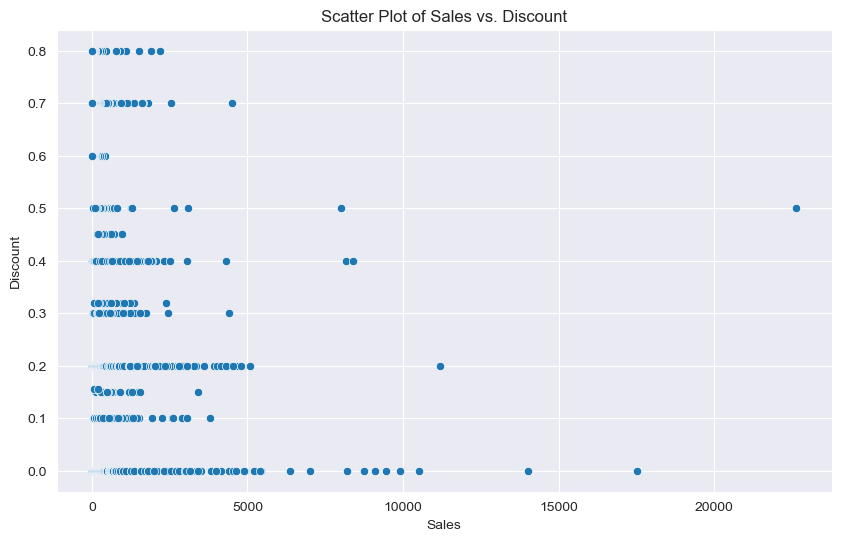

In [114]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_numeric_cust_features['Sales'], y= df_numeric_cust_features['Discount'])

# Add titles and labels
plt.title('Scatter Plot of Sales vs. Discount')
plt.xlabel('Sales')
plt.ylabel('Discount')

# Show the plot
plt.show()


Task 2

2.2 Outlier treatment.
 
* in previous section every initiative reinforced the notion of outliers e.g. mean, median, variance and standard deviation. 
* The high skew 12 and kurtosis 305 used with our sales leaves no doubt that there are big outliers (sales transactions) in the numeric dataset skewing the result.
* The 90 - 100th percentile has a significant jump due to the outlier big sales.


In [48]:
df_numeric_cust_features['Sales'].skew()

12.972741318960942

In [122]:
kurtosis_value = df_numeric_cust_features['Sales'].kurtosis()
print(kurtosis_value)

305.3118017200354


In [157]:
percentile_value = np.percentile(df_numeric_cust_features['Sales'], 95)
print(percentile_value)

956.9842450000003



2.2.1 Sales distribution

The Sales data is a positive skew to the right this means
* There are a few outliers Sales that pull the average up (mean 229 vs median 55).
* The majority of sales transactions are much smaller (mode) €12.96
* The business risk is the firm relies on a few big outliers to balance the books.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


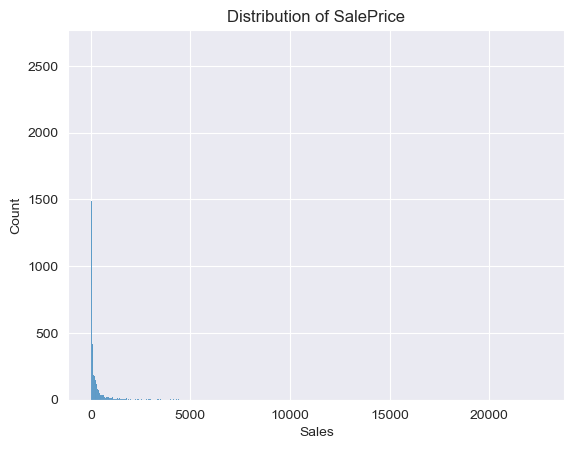

<Figure size 640x480 with 0 Axes>

In [125]:

def distribution_graph():
    sns.histplot(df_numeric_cust_features['Sales']).set_title("Distribution of SalePrice")
    fig = plt.figure()
    #res = stats.probplot(df_numeric_cust_features['Sales'], plot=plt)
    plt.show()

distribution_graph()


2.2.2 Probability plot

* from -4 to + 2 the sales are evenly distributed, however after 2 the outliers dramatically break away from the mean.


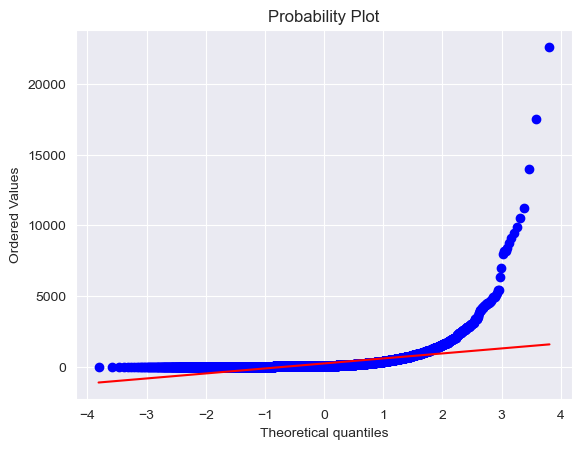

In [127]:
fig = plt.figure()
res = stats.probplot(df_numeric_cust_features['Sales'], plot=plt)
plt.show()

2.2.3 Outlier Treatment: delete outliers

After removing the outliers / big sales (greater than €10,000)
* we get half a bell of the normal distribution.
* the mode() result advised the most reoccurring sale is €12.96 which fits with this model.
* the median 55 fits about right in this scenario.



0       2.241991
1       2.301316
2       2.161762
3       2.179766
4       2.145329
          ...   
9989    2.317855
9990    2.322354
9991    2.328177
9992    2.355830
9993    2.376765
Name: Sales, Length: 9994, dtype: float64
         Sales  Quantity  Discount     Profit
0     2.241991       5.0       0.7 -6599.9780
1     2.301316       4.0       0.5 -3839.9904
2     2.161762       8.0       0.8 -3701.8928
3     2.179766       5.0       0.7 -3399.9800
4     2.145329       5.0       0.8 -2929.4845
...        ...       ...       ...        ...
9989  2.317855       5.0       0.0  4630.4755
9990  2.322354      13.0       0.0  4946.3700
9991  2.328177       3.0       0.0  5039.9856
9992  2.355830       4.0       0.0  6719.9808
9993  2.376765       5.0       0.0  8399.9760

[9994 rows x 4 columns]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


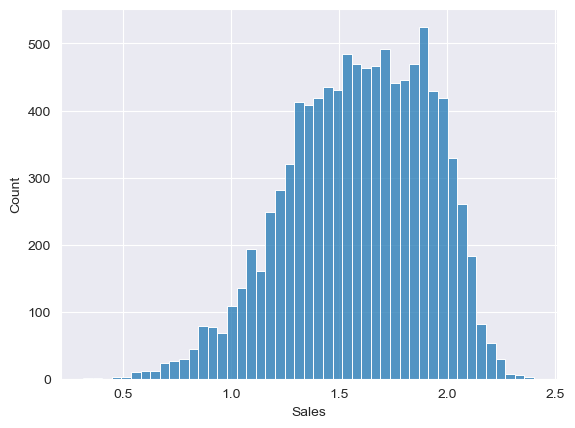

In [164]:
def distribution_graph_no_outlier():
    # with data capture below 1000 this shows a part of the distribution.

    print(df_numeric_cust_features['Sales'])
    # df_numeric_no_outlier = df_numeric_cust_features.drop(df_numeric_cust_features['Sales'] > 6000)
    df_numeric_no_outlier = df_numeric_cust_features[df_numeric_cust_features['Sales'] <= 1000]
    sns.histplot(df_numeric_no_outlier['Sales'])
    print(df_numeric_no_outlier)
    plt.show()
    

distribution_graph_no_outlier()

2.2.4 Outlier treatment: Log transformation

* will reduce impact of outliers as below
* will make data more normally distributed
* distribution supports 0.50 median.
* risk sales figures are changed.
* model is still skewed.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


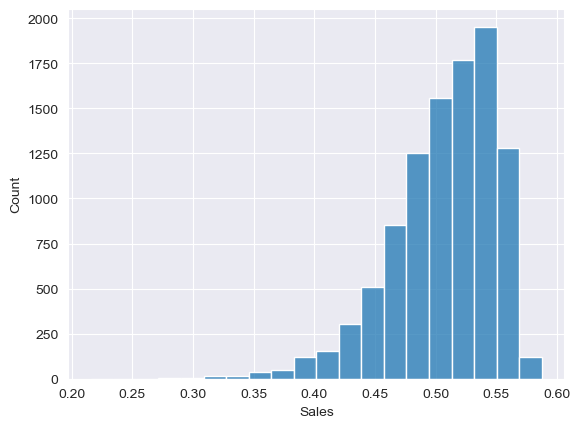

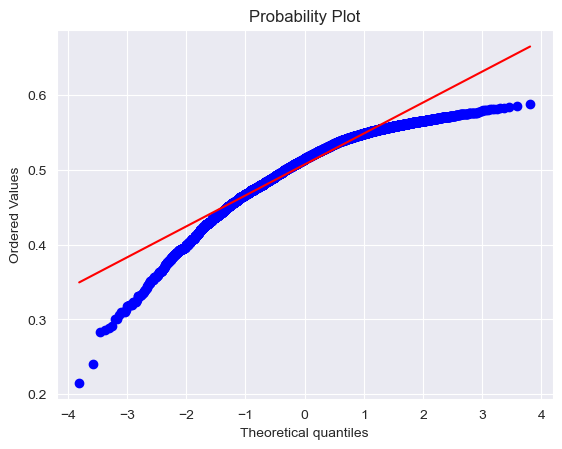

In [169]:
df_numeric_logchange = pd.DataFrame()
df_numeric_logchange['Sales'] = np.log1p(df_numeric_cust_features['Sales'])
sns.histplot(df_numeric_logchange['Sales'], bins=20)
# probability plot
fig = plt.figure()
res = stats.probplot(df_numeric_logchange['Sales'], plot=plt)
plt.show()

In [171]:
df_numeric_logchange['Sales'].mean()

0.5071263917292045

In [172]:
df_numeric_logchange['Sales'].median()

0.5146992513243358

In [176]:
df_numeric_logchange['Sales'].skew()

-1.1022766887817583

In [177]:
df_numeric_logchange['Sales'].kurtosis()

1.8028068606011072

In [178]:
df_numeric_logchange['Sales'].std()

0.04279971900240532

3.0 Normalization and Scaling

3.1 Standard scaler tries to make data distributed and reduces the skew but it seems that it is affected by outliers. It scales the data to a fixed range between 0 and 1. 

In [244]:
scaler_numeric = StandardScaler()

df_scaled_numeric_features = pd.DataFrame(scaler_numeric.fit_transform(df_numeric_cust_features[['Sales','Quantity','Profit','Discount']]),columns=['Sales','Quantity','Profit','Discount'])
print(df_scaled_numeric_features)

         Sales  Quantity     Profit  Discount
0     1.662075  0.544437 -28.440893  2.635324
1     1.781422  0.094835 -16.599617  1.666135
2     1.495506  1.893242 -16.007132  3.119918
3     1.533419  0.544437 -14.711825  2.635324
4     1.460624  0.544437 -12.693241  3.119918
...        ...       ...        ...       ...
9989  1.814138  0.544437  19.741533 -0.756837
9990  1.822997  4.141251  21.096827 -0.756837
9991  1.834437 -0.354766  21.498469 -0.756837
9992  1.888370  0.094835  28.706214 -0.756837
9993  1.928773  0.544437  35.913959 -0.756837

[9994 rows x 4 columns]


The coeff and intercept.
* the negative implies for each std. deviation increase of discount sales DECREASE by 0.211.
* four each standard deviation increase in quantity the sales increase 0.320.
* the profit has NO IMPACT on the sales.

In [252]:
from sklearn.linear_model import LinearRegression

x_scaled = df_scaled_numeric_features[['Discount','Quantity','Profit']]
y_scaled = df_scaled_numeric_features['Sales']

reg_model = LinearRegression()
reg_model.fit(x_scaled, y_scaled)
print(reg_model.coef_)
print(reg_model.intercept_)



[-0.21135734  0.32013178  0.07801244]
3.275121249419437e-16


we can transform the data for further analysis with some feature engineering.

In [257]:
df_scaled_numeric_features['Scaled_Total_Revenue'] = df_scaled_numeric_features['Sales'] * df_scaled_numeric_features['Quantity']
df_scaled_numeric_features['Scaled_Profit_margin'] = df_scaled_numeric_features['Profit'] / df_scaled_numeric_features['Sales']
print(df_scaled_numeric_features)


         Sales  Quantity     Profit  Discount  Scaled_Total_Revenue  \
0     1.662075  0.544437 -28.440893  2.635324              0.904895   
1     1.781422  0.094835 -16.599617  1.666135              0.168942   
2     1.495506  1.893242 -16.007132  3.119918              2.831355   
3     1.533419  0.544437 -14.711825  2.635324              0.834850   
4     1.460624  0.544437 -12.693241  3.119918              0.795218   
...        ...       ...        ...       ...                   ...   
9989  1.814138  0.544437  19.741533 -0.756837              0.987684   
9990  1.822997  4.141251  21.096827 -0.756837              7.549489   
9991  1.834437 -0.354766  21.498469 -0.756837             -0.650796   
9992  1.888370  0.094835  28.706214 -0.756837              0.179084   
9993  1.928773  0.544437  35.913959 -0.756837              1.050095   

      Scaled_Profit_margin  
0               -17.111683  
1                -9.318184  
2               -10.703489  
3                -9.594132  
4 

In [237]:
df_scaled_numeric_features.corr()

,Sales,Quantity,Profit,Discount
Sales,1.000000,0.324078,0.146948,-0.225844
Quantity,0.324078,1.000000,0.071662,0.007778
Profit,0.146948,0.071662,1.000000,-0.217615
Discount,-0.225844,0.007778,-0.217615,1.000000


In [239]:
scaled_stats= df_scaled_numeric_features.describe()
print(scaled_stats)

             Sales     Quantity       Profit     Discount
count  9994.000000  9994.000000  9994.000000  9994.000000
mean      0.754243     0.214544     0.441939     0.195224
std       0.124508     0.171100     0.015540     0.257961
min       0.000000     0.000000     0.000000     0.000000
25%       0.679766     0.076923     0.440117     0.000000
50%       0.774163     0.153846     0.440579     0.250000
75%       0.851475     0.307692     0.441957     0.250000
max       1.000000     1.000000     1.000000     1.000000


3.2 Standardization

I applied the Min Max to my existing numeric values to standardise. This should make all numeric features similar ranges and be considered equally and is essential for downstream machine learning.


In [253]:
min_max_scaler = MinMaxScaler()
df_numeric_cust_features_scaled = min_max_scaler.fit_transform(df_numeric_cust_features)

df_numeric_cust_features_scaled = pd.DataFrame(df_numeric_cust_features_scaled, columns=df_numeric_cust_features.columns)

df_numeric_cust_features_scaled.head()

,Sales,Quantity,Discount,Profit
0,0.961174,0.307692,0.875,0.000000
1,0.976033,0.230769,0.625,0.184000
2,0.940436,0.538462,1.000,0.193206
3,0.945156,0.307692,0.875,0.213334
4,0.936093,0.307692,1.000,0.244700


futher transformations from the min_max scaled numbers could be

4.0 Grouping of data:
* into numeric financial and categorical, product and customer based on shared characteristics
* the combination of several separate elements.
* using the heatmap i can confirm there are no numeric multi-collinearity features
* we look at data aggregations around sales achieved per year which shows the revenue trend over time.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     9994 non-null   float64
 1   Quantity  9994 non-null   float64
 2   Discount  9994 non-null   float64
 3   Profit    9994 non-null   float64
dtypes: float64(4)
memory usage: 312.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product ID    9992 non-null   object
 1   Category      9992 non-null   object
 2   Sub-Category  9990 non-null   object
 3   Product Name  9991 non-null   object
dtypes: object(4)
memory usage: 312.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Order ID       9993 n

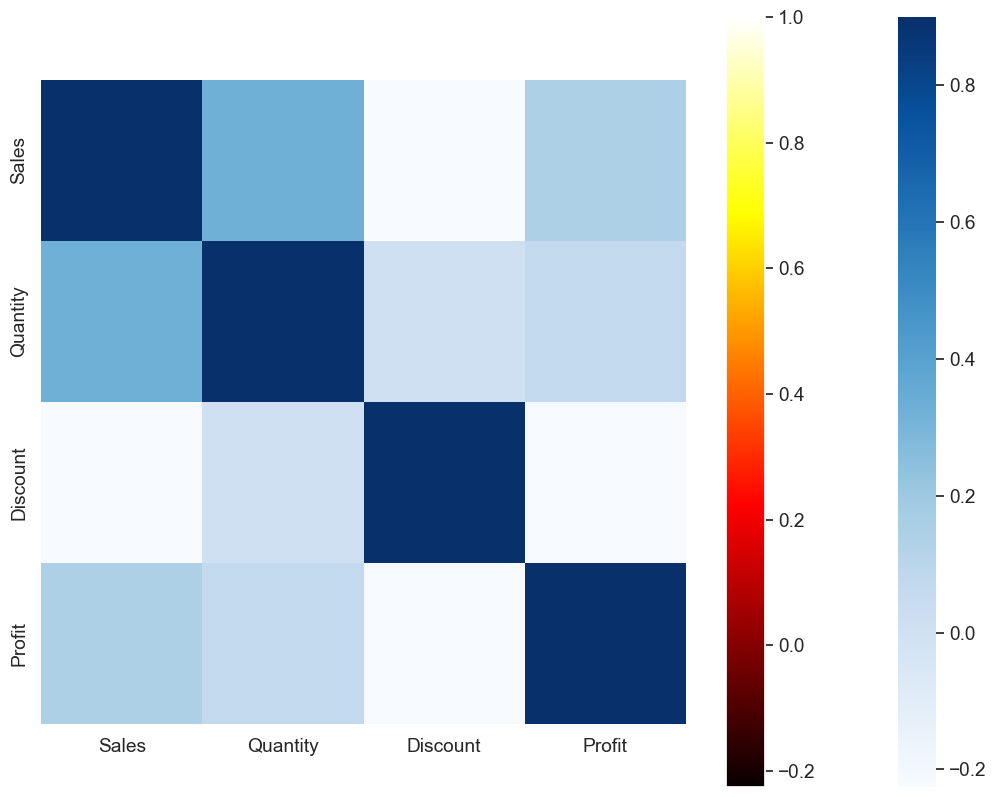

In [293]:
df_product = df_categorical_cust_info.drop(['Order Date','Ship Date','Order Date','Ship Mode','Customer ID','Customer Name','Segment','Country','City','State','Postal Code','Region','Order ID','Row ID'], axis=1 )

df_customer = df_categorical_cust_info.drop(['Product Name', 'Product ID','Sub-Category','Category','Ship Mode','Ship Date','Row ID','Order Date'], axis=1)

#logsitics
corrmat = df_numeric_cust_features_scaled.corr()


def show_heatmap_one():
    plt.subplots(figsize=(13, 10))
    sns.heatmap(corrmat, vmax=0.9, cmap="Blues", square=True)
    # Create the heatmap using Matplotlib's imshow function
    plt.imshow(corrmat, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()


df_numeric_cust_features_scaled.info()
df_product.info()
df_customer.info()
show_heatmap_one()


Data aggregations around yearly sales

In [340]:
# Step 1: Replace "$April" with "04/11/2015" in the 'Order Date' column using a dictionary for explicit replacement

df_categorical_cust_info['Order Date'] = df_categorical_cust_info['Order Date'].replace({'$April': '04/11/2015'})

# Verify the replacement
print("Categorical Cust Info after replacement:")
print(df_categorical_cust_info['Order Date'])

Categorical Cust Info after replacement:
0      2016-11-25
1      2017-04-11
2      2014-07-26
3      2017-04-17
4      2017-07-12
          ...    
9989   2014-09-23
9990   2016-12-17
9991   2017-11-17
9992   2017-03-23
9993   2016-02-10
Name: Order Date, Length: 9994, dtype: datetime64[ns]


In [341]:
df_categorical_cust_info['Sales'] = df_numeric_cust_features['Sales']

In [342]:
# Step 2: Convert the 'Order Date' column to datetime objects
df_categorical_cust_info['Order Date'] = pd.to_datetime(df_categorical_cust_info['Order Date'], dayfirst=True, errors='coerce')
print(df_categorical_cust_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9993 non-null   object        
 2   Order Date     9992 non-null   datetime64[ns]
 3   Ship Date      9991 non-null   object        
 4   Ship Mode      9990 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9991 non-null   object        
 7   Segment        9991 non-null   object        
 8   Country        9990 non-null   object        
 9   City           9992 non-null   object        
 10  State          9990 non-null   object        
 11  Postal Code    9991 non-null   object        
 12  Region         9991 non-null   object        
 13  Product ID     9992 non-null   object        
 14  Category       9992 non-null   object        
 15  Sub-Category   9990 n

In [344]:
# Step 3: Create date range for bins 
bins = pd.date_range(start='2014-01-01', end='2018-01-01', freq='YS')
labels = [str(year.year) for year in bins[:-1]]
print(labels)

['2014', '2015', '2016', '2017']


In [346]:
# Step 4: Categorize the dates into bins
df_categorical_cust_info['Year_Bin'] = pd.cut(df_categorical_cust_info['Order Date'], bins=bins, labels=labels)


In [ ]:
# Step 5: Group by these bins and sum the 'Sales' values
sales_by_years_bin = df_categorical_cust_info.groupby('Year_Bin', observed=False)['Sales'].sum().reset_index()

In [355]:
sales_by_years_bin.sort_values(by='Year_Bin', ascending=True, inplace=True)
# Verify the grouped sales data
print("Sales by Year Bin:")
print(sales_by_years_bin)
print("Gross sales for period")
print(sales_by_years_bin.Sales.sum())



Sales by Year Bin:
  Year_Bin        Sales
0     2014  1316.673211
1     2015  1392.567907
2     2016  1721.625356
3     2017  2183.778826
Gross sales for period
6614.64529988617


Frequency distribution


In [368]:
print(df_categorical_cust_info.columns)
print(df_categorical_cust_info.info())
df_categorical_cust_info_small = df_categorical_cust_info.sample(n=10, random_state=1)
(df_categorical_cust_info_small.shape)

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Year_Bin', 'Sales'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9993 non-null   object        
 2   Order Date     9992 non-null   datetime64[ns]
 3   Ship Date      9991 non-null   object        
 4   Ship Mode      9990 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9991 non-null   object        
 7   Segment        9991 non-null   object        
 8   Country        9990 non-null   object        
 9   City           9992 non-null   object  

(10, 19)

In [369]:
ship_mode_frequency = df_categorical_cust_info_small.groupby('Ship Mode').value_counts()
print(ship_mode_frequency)

MemoryError: Unable to allocate 1.55 PiB for an array with shape (1741824000000000,) and data type int8

6.0 The correlation: 
6.1 covariance 

* When sales increase, profit and quantity go up
* When sales decrease discounting goes up.
* When profits go up, sales and quantity go up.
* There is no relationship between discount and quantity

In [123]:
numeric_covariance = df_numeric_cust_features.cov()
print(numeric_covariance)

                  Sales    Quantity   Discount        Profit
Sales     388434.121558  278.147547  -3.621752  70946.464970
Quantity     278.147547    4.947520   0.003570     37.154452
Discount      -3.621752    0.003570   0.042588    -10.467963
Profit     70946.464970   37.154452 -10.467963  54332.628202


6.2 The correlation
* When Sales go down, discounting goes up.
* When sales go up, profit and quantity sold goes up.
* when profit goes up quantity sold and sales goes up.
* when profit goes down, discounting goes up.
* There is no covariance between Discount and Quantity.

In [98]:
correlation = df_numeric_cust_features.corr()
print(correlation)

             Sales  Quantity  Discount    Profit
Sales     1.000000  0.200642 -0.028159  0.488362
Quantity  0.200642  1.000000  0.007778  0.071662
Discount -0.028159  0.007778  1.000000 -0.217615
Profit    0.488362  0.071662 -0.217615  1.000000


6.3 The following insights from correlation: Sales and Profit
* The positive relationship with sales and profit suggest as sales increase profit increase.
* there is not a strong linear relationship with sales and profit and other factors can also influence profit.
* The graph implies that just under half the sales made where at a loss to the business.
* The reult is between -1 and 1.




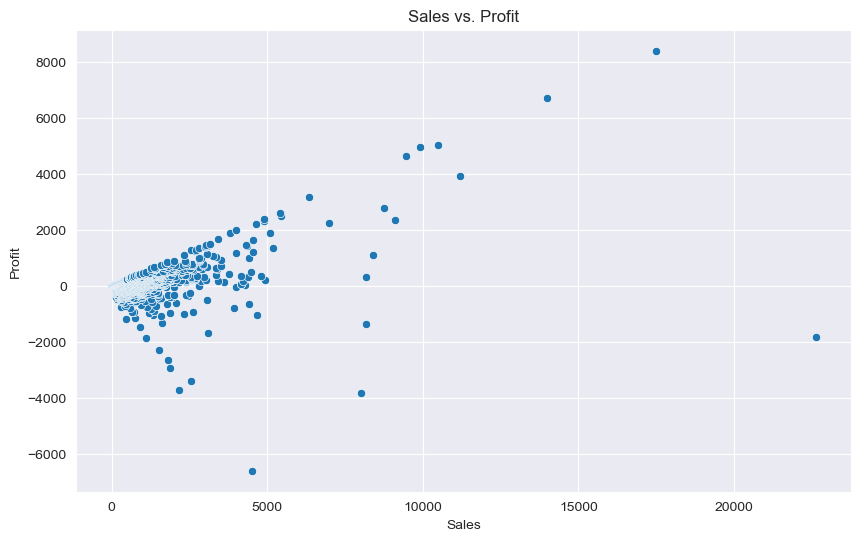

In [108]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_numeric_cust_features['Sales'], y=df_numeric_cust_features['Profit'])
plt.title('Sales vs. Profit')
plt.ylabel('Profit')
plt.xlabel('Sales')
plt.show()





6.4 The insights from correlation Sales to Quantity

* The positive 0.200 implies as quantity sold increases sales does as well.
* because the result is low / weak other factors can have a big impact on sales.




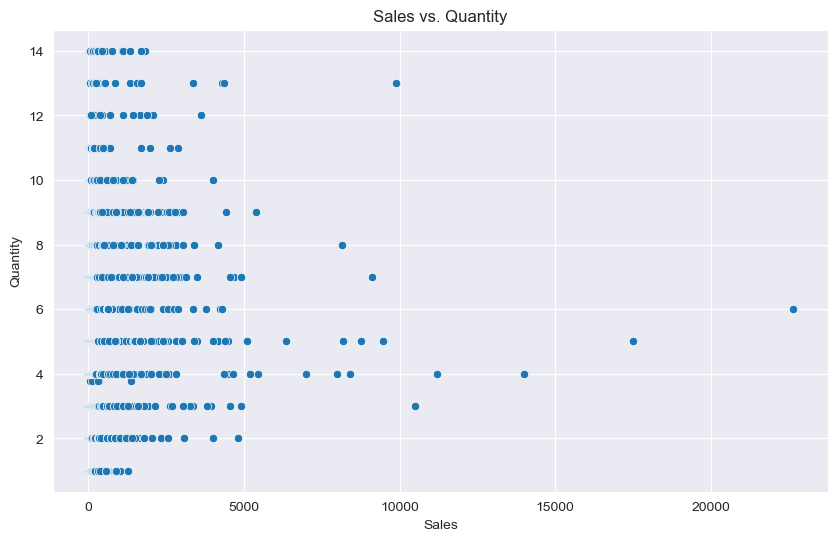

In [103]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_numeric_cust_features['Sales'], y=df_numeric_cust_features['Quantity'])
plt.title('Sales vs. Quantity')
plt.xlabel('Sales')
plt.ylabel('Quantity')
plt.show()
